### Testing PGMM
This is to test all the model of the family PGMM and check that everything looks OK, given a dummy example.

In [1]:
# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy
import matplotlib.pyplot
import time

from scipy import linalg
from sklearn.datasets import make_blobs
from sklearn import mixture

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from matplotlib.colors import LogNorm

In [2]:
# # Create the data
# N = 3000 # number of data points
# train_perct = 0.8
# t = numpy.linspace(0, 4*numpy.pi, N)
# feature1 = 6.0*numpy.sin(8*t+0.001) + 0.5 + 0.6*numpy.random.randn(N) # create artificial data with noise
# feature2 = 6.0*numpy.cos(8*t+0.001) + 0.5 + 0.6*numpy.random.randn(N) # create artificial data with noise
# X = numpy.vstack((feature1, feature2)).T
# train_idxs = numpy.arange(int(numpy.round(train_perct*N)))
# val_idxs = numpy.arange(int(numpy.round(train_perct*N)), N)

# t_train = t[train_idxs]
# t_val = t[val_idxs]
# X_train = X[train_idxs, :]
# X_val = X[val_idxs, :]

# print 'Created {} training samples.'.format(len(t_train))
# print 'Created {} validation samples.'.format(len(t_val))
# matplotlib.pyplot.figure()
# matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1])
# matplotlib.pyplot.scatter(X_val[:, 0], X_val[:, 1], color='red')
# matplotlib.pyplot.legend(['Training Data Set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# matplotlib.pyplot.title('Data set')
# matplotlib.pyplot.ylabel('Feature 1')
# matplotlib.pyplot.xlabel('Feature 2')
# matplotlib.pyplot.grid()
# matplotlib.pyplot.show()

Created 5000 samples wih 2 features and 3 centers.
The data set was divided into 3750 training samples and 1250 testing samples.


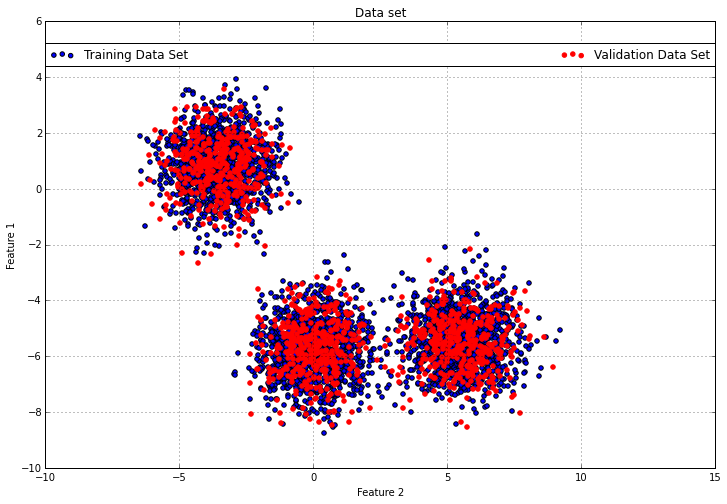

In [3]:
# Create and display data set
n_samples = 5000
n_features = 2
centers = 3

X, y = make_blobs(n_samples=n_samples, 
               n_features=n_features, 
               centers=centers)
print 'Created {} samples wih {} features and {} centers.'.format(X.shape[0], X.shape[1], centers)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)
t_train = numpy.arange(X_train.shape[0])
t_val = numpy.arange(y_val.shape[0]) + X_train.shape[0]
print 'The data set was divided into {} training samples and {} testing samples.'.format(X_train.shape[0], X_val.shape[0])
# If the data set has is bi-dimensional, scatter plot it
if n_features == 2:
    matplotlib.pyplot.figure(figsize=(12, 8))
    matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1])
    matplotlib.pyplot.scatter(X_val[:, 0], X_val[:, 1], color='red')
    matplotlib.pyplot.legend(['Training Data Set', 'Validation Data Set'], bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
               ncol=2,mode="expand", borderaxespad=0.)
    matplotlib.pyplot.title('Data set')
    matplotlib.pyplot.ylabel('Feature 1')
    matplotlib.pyplot.xlabel('Feature 2')
    matplotlib.pyplot.grid()
    matplotlib.pyplot.show()
    

In [4]:
num_comp = 7
n_pc = 1
# Store de models
models = {}

Start training model with 7 components, 1 and RRR covariance.
     Model 7-RRR trained in 0.16411614418 seconds.
     PGMM(covariance_type='RRR', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 23 parameters.


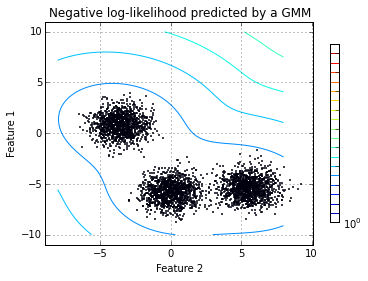

The threshold via Monte Carlo is 8.84841629749


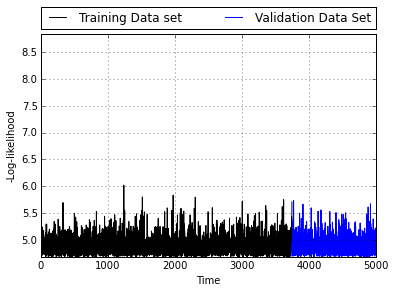

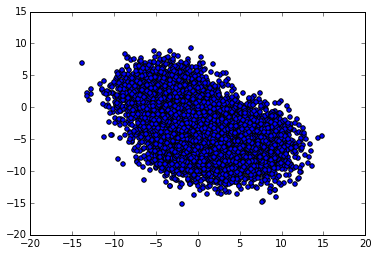

In [5]:
covariance_type = 'RRR'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and RRU covariance.
     Model 7-RRU trained in 0.154796123505 seconds.
     PGMM(covariance_type='RRU', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 24 parameters.


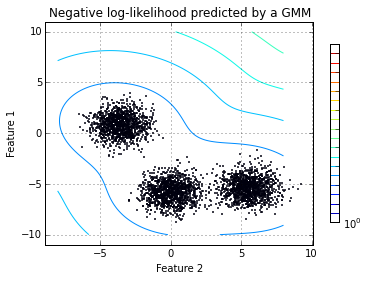

The threshold via Monte Carlo is 8.7753705688


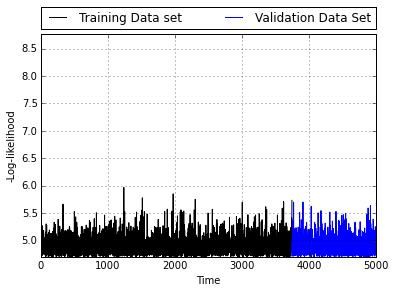

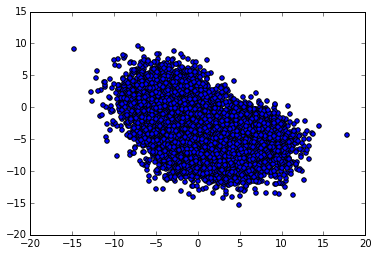

In [6]:
covariance_type = 'RRU'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and RUR covariance.
     Model 7-RUR trained in 0.159379959106 seconds.
     PGMM(covariance_type='RUR', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 29 parameters.


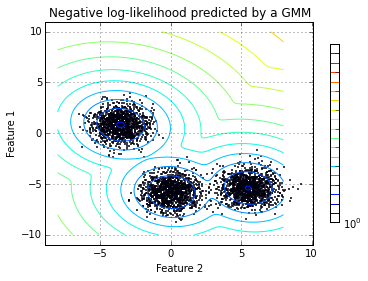

The threshold via Monte Carlo is 7.16737205894


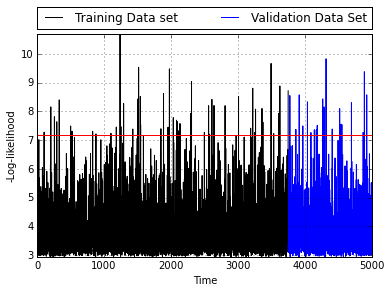

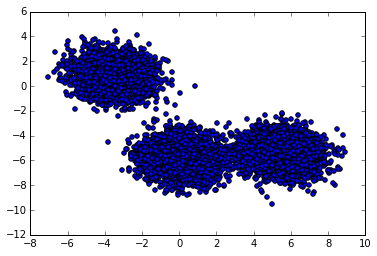

In [7]:
covariance_type = 'RUR'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and RUU covariance.
     Model 7-RUU trained in 0.141632795334 seconds.
     PGMM(covariance_type='RUU', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 36 parameters.


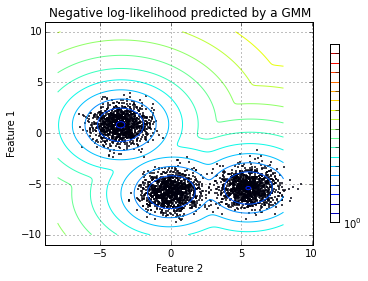

The threshold via Monte Carlo is 7.40526766768


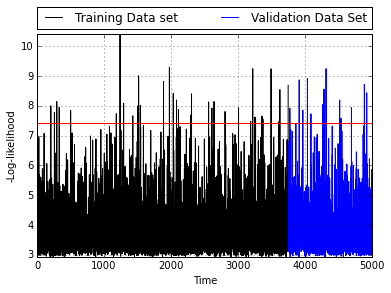

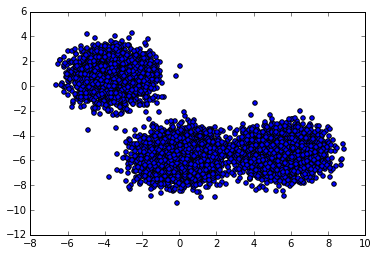

In [8]:
covariance_type = 'RUU'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and URR covariance.
     Model 7-URR trained in 0.164554834366 seconds.
     PGMM(covariance_type='URR', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 35 parameters.


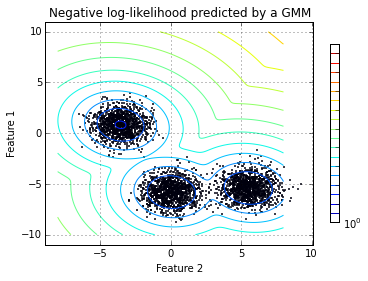

The threshold via Monte Carlo is 7.55917981253


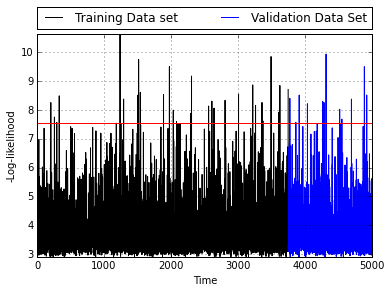

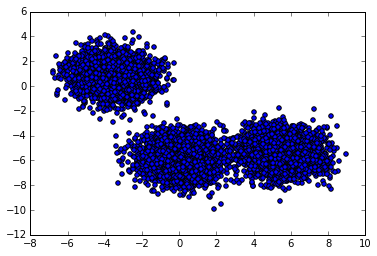

In [9]:
covariance_type = 'URR'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and URU covariance.
     Model 7-URU trained in 0.174762964249 seconds.
     PGMM(covariance_type='URU', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 36 parameters.


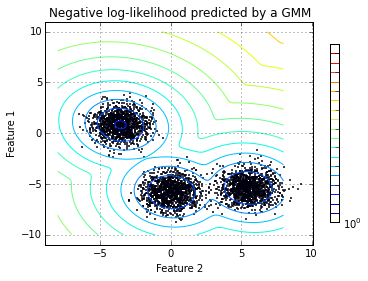

The threshold via Monte Carlo is 7.3619291428


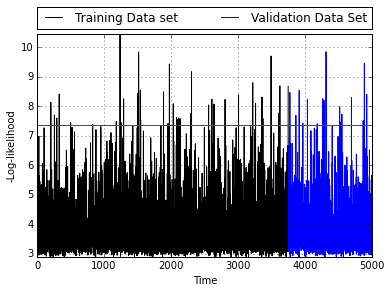

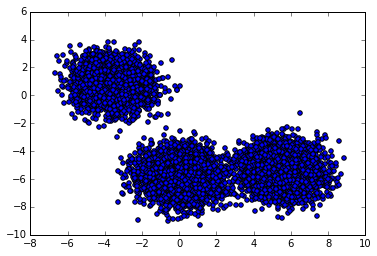

In [10]:
covariance_type = 'URU'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and UUR covariance.
     Model 7-UUR trained in 0.135869026184 seconds.
     PGMM(covariance_type='UUR', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 41 parameters.


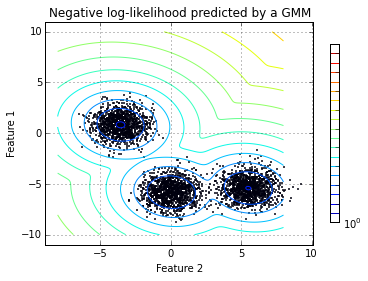

The threshold via Monte Carlo is 7.46240890579


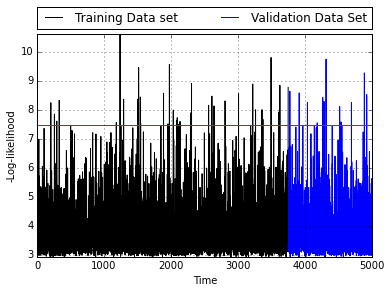

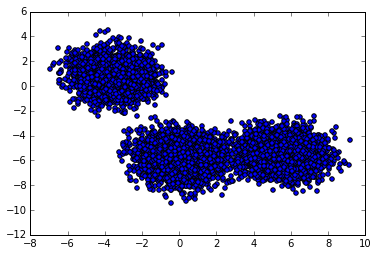

In [11]:
covariance_type = 'UUR'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])

Start training model with 7 components, 1 and UUU covariance.
     Model 7-UUU trained in 0.154702186584 seconds.
     PGMM(covariance_type='UUU', init_params='wmpn', min_covar=1e-07,
   n_components=7, n_init=1, n_iter=100, n_pc=1, params='wmpn',
   random_state=None, tol=0.001, verbose=0)
     The model has 48 parameters.


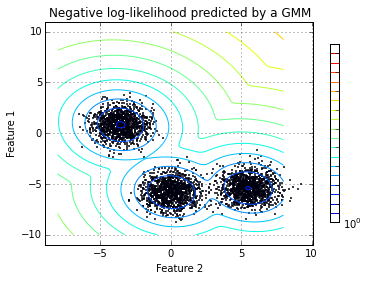

The threshold via Monte Carlo is 7.39357846582


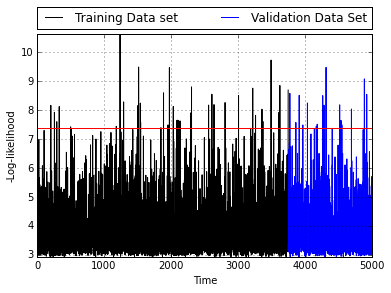

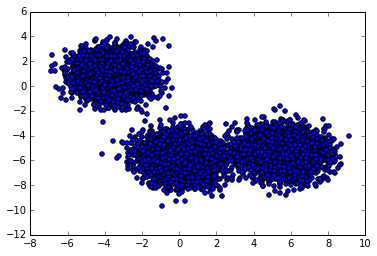

In [12]:
covariance_type = 'UUU'
model = mixture.PGMM(n_components=num_comp,
                     n_pc=n_pc,
                     covariance_type=covariance_type,)
print 'Start training model with {} components, {} and {} covariance.'.format(num_comp, n_pc, covariance_type)
start = time.time()
model.fit(X_train)
end = time.time()
models[covariance_type] = model
print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_type, end - start)
print '     {}'.format(model)
print '     The model has {} parameters.'.format(model._n_parameters())

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0, 1000)
y = numpy.linspace(-10.0, 10.0, 1000)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = model.sample(N_sample)
logprob_sample, responsability_sample = model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = model.score_samples(X_train)
logprob_val, responsability_val = model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

matplotlib.pyplot.scatter(best_model_sample[:, 0], best_model_sample[:, 1])